In [5]:
# Импорт библиотек

import os
import osmnx as ox # экспорт данных осм
import numpy as np # работа с массивами
import scipy # статистический
import pandas as pd # серии и фреймы данных
import shapely # работа с геометрией
import geopandas as gpd # геодатафреймы и геосерии
import libpysal as lps # пространсвенная эконометрика
from libpysal.weights import *
import matplotlib.pyplot as plt # визуализация
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify as mc# методы символизации
%matplotlib inline

## Работа с исходными данными

In [7]:
# получение текущей рабочей директории
print(os.getcwd())

# изменение директории Minsk_2017
os.chdir('Minsk_2017');

/home/milvari/EnvProj/myenv/scripts/Minsk/Minsk_2017


FileNotFoundError: [Errno 2] No such file or directory: 'Minsk_2017'

In [8]:
# чтение основного геодатафрейма данных
# вторичная недвижимость, Минск, 2017 год
m17 = gpd.read_file('m17.shp')
m17.head()

,FID_,rooms,street_nam,house_numb,building_n,price_m2,area_total,year,house_type,x,...,centre_dis,parks_dist,metro_dist,hospitals_,schools_di,transport_,highways_d,industrial,heavy_dist,geometry
0,0.0,1.0,?????? 120 ??????? ??.,27.0,0.0,1284.0,49.0,2012.0,1.0,27.723200,...,11491.910810,135.390274,2222.593697,800.867506,23.757774,271.166518,1510.844907,330.537641,9790.230326,POINT (547470.348 5977366.418)
1,1.0,1.0,?????? 120 ??????? ??.,29.0,0.0,1327.0,49.0,2012.0,1.0,27.723900,...,11512.732574,88.845893,2277.003627,869.830404,54.368808,204.024323,1562.897062,369.104082,9748.626153,POINT (547516.863 5977311.258)
2,3.0,1.0,?????? 120 ??????? ??.,29.0,0.0,1633.0,49.0,2013.0,1.0,27.723900,...,11512.732574,88.845893,2277.003627,869.830404,54.368808,204.024323,1562.897062,369.104082,9748.626153,POINT (547516.863 5977311.258)
3,4.0,1.0,?????? 120 ??????? ??.,33.0,0.0,1190.0,47.0,2012.0,1.0,27.724920,...,11553.453539,60.658296,2352.969795,948.045267,62.013553,128.830758,1615.929085,415.154853,9713.212466,POINT (547584.383 5977256.426)
4,5.0,1.0,???????? ??.,14.0,0.0,854.0,48.0,1970.0,5.0,27.741279,...,13326.208329,23.739358,3673.255016,1803.396153,1964.565168,302.368797,1052.783426,300.205268,11828.408859,POINT (548638.498 5979149.329)


## Проверка корреляции между факторами - через матрицу ковариации

/tmp/ipykernel_113688/402930146.py:5: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(m17.corr(),annot=True, fmt='.2g', cmap='spring')


<AxesSubplot: >

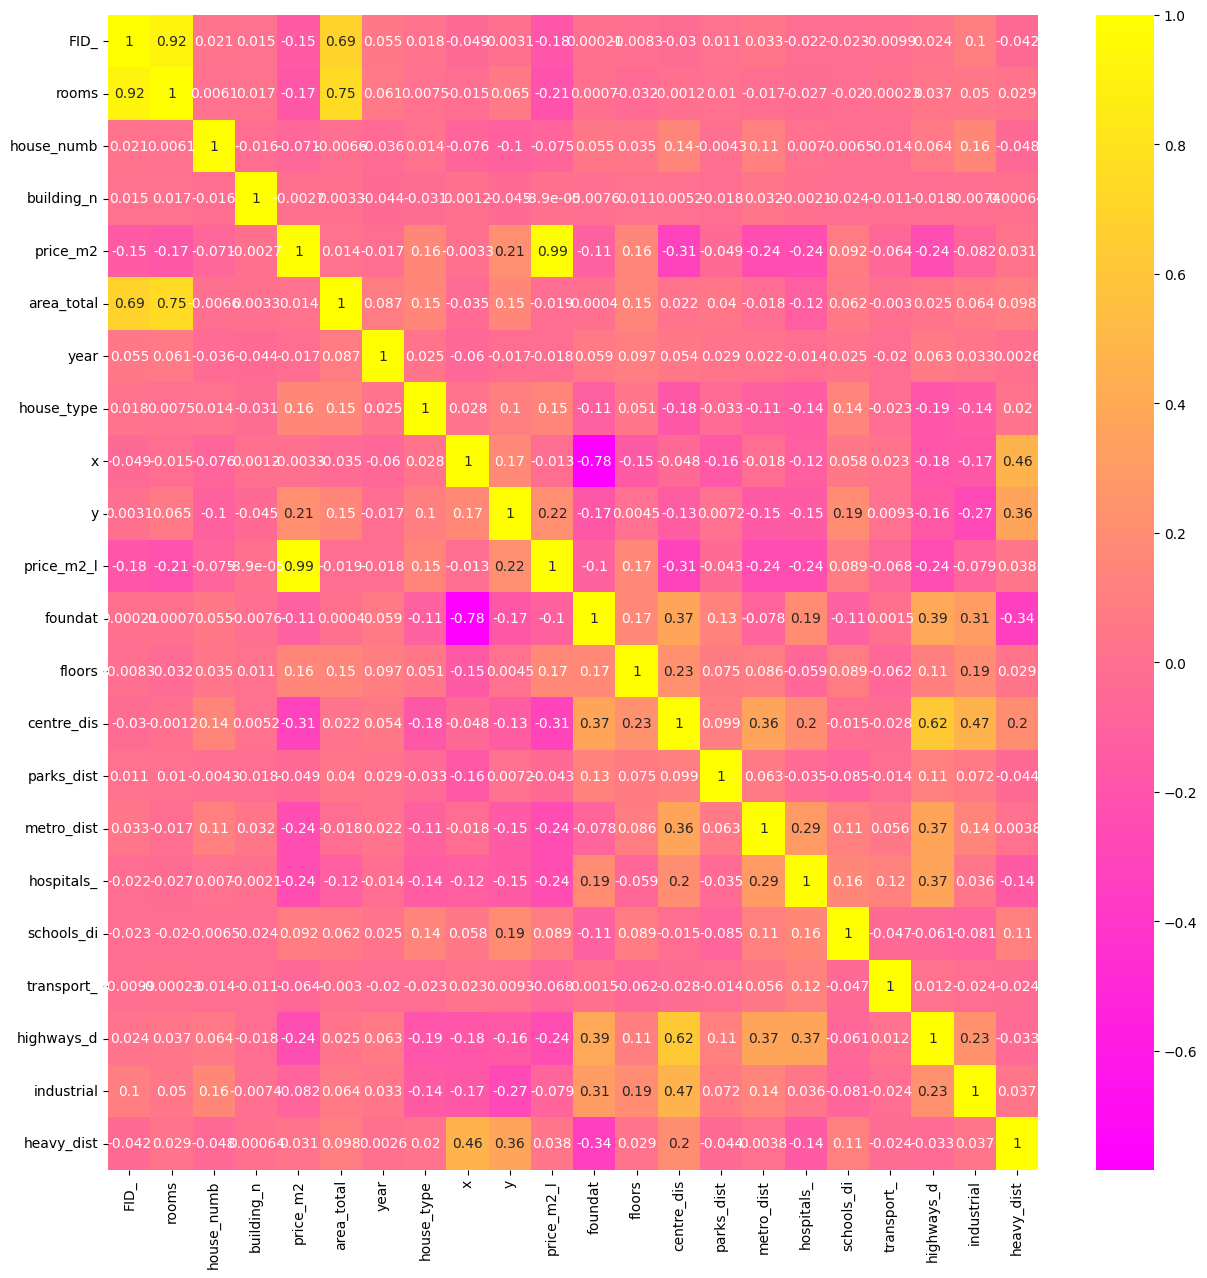

In [9]:
import seaborn as sns

# получение матрицы корреляций значений - видна корреляция только комнатности и общей площади
plt.figure(figsize=(15,15))
sns.heatmap(m17.corr(),annot=True, fmt='.2g', cmap='spring')

## Пространсвенная эконометрика

### 1) Просмотрим распределение цен по Минску, при помощи простой визуализации

In [61]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

<function matplotlib.pyplot.show(close=None, block=None)>

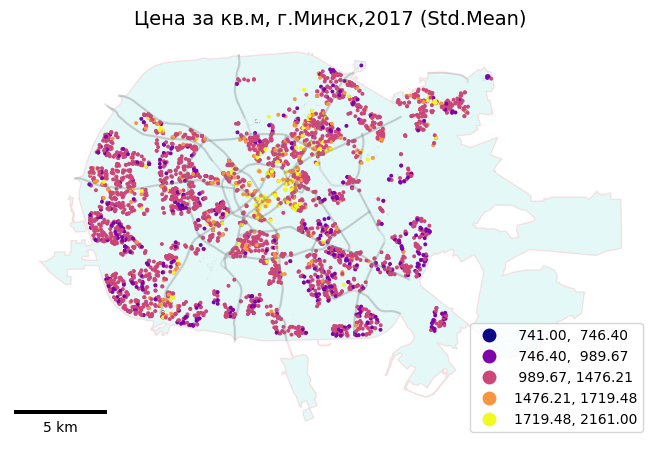

In [62]:
f,ax = plt.subplots (1, figsize = (8.26,5.826)) # 2551x1795 - A5 (dpi-300)

minsk.plot(ax=ax, color = 'c',alpha = .1, edgecolor = 'red')
highways.plot(ax=ax, color = 'grey', alpha = 0.2)
buildings.plot(ax=ax, color='grey', alpha = 0.5)


m17.plot(column = 'price_m2',
         ax=ax,
         scheme = 'StdMean',
         cmap = 'plasma',
         markersize= 8,
         edgecolor = 'none',
         legend= True)
ax.set_title('Цена за кв.м, г.Минск,2017 (Std.Mean)',
             fontsize = 14)
#ax.legend(loc='lower left')
# scalebar = AnchoredSizeBar(ax.transData, 1, "1 Meter", 9)
ax.add_artist(ScaleBar(dx = 1,
                       location = 'lower left'
                      ),) # 1 pixel = 1 м
# m17.legend(frameon=False, loc=0, ncol=2)
ax.set_axis_off()
plt.show
#plt.savefig('StdMean.png', format='png', dpi=300)

## Пространственные весы (выбран Kernel weights - весы расстояния, отражающие первый закон Тоблера) - выражают феномен соседства (spatial similarity)

In [63]:
# Сontinuously valued weights
# to reflect Tobler’s first law [Tob70] in a more direct way:
# observations that are close to a unit have larger weights
# than more distant observations.

# reflect the case where similarity/spatial proximity
# is assumed or expected to decay with distance

# The essence of kernel weights is
# that the weight between observations i and j is based on
# their distance,
# but it is further modulated by a kernel function
#with certain properties

In [64]:
#from scipy.spatial import Voronoi,voronoi_plot_2d
#from shapely.geometry import Point, MultiPolygon, Polygon

points = (list(zip(m17['x'], m17['y'])))
points = np.array(points)

In [65]:
kw = Kernel(points,fixed = False,
            k = 20) # адаптивные - 20 соседей

/home/milvari/EnvProj/myenv/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [66]:
kw.neighbors [0] # expressing neighboor relationships
             # by expressing the focal observation on the left and right

[0,
 2,
 1,
 1729,
 6,
 2851,
 3,
 2849,
 2848,
 2341,
 2752,
 157,
 158,
 1070,
 1764,
 159,
 1071,
 1755,
 1756,
 2359,
 2358]

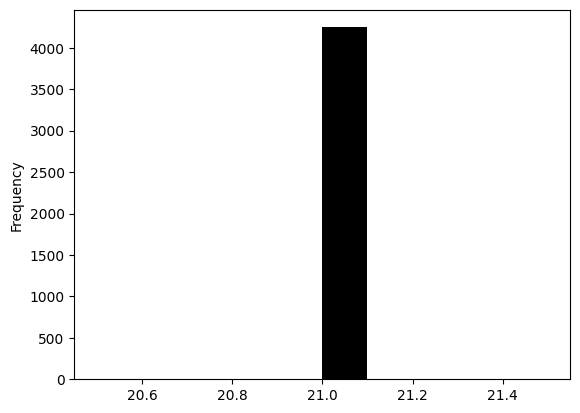

In [67]:
c = kw.cardinalities;
pd.Series(c).plot.hist(color="k");

In [68]:
kw.weights[0]

[1.0,
 0.8946773466974314,
 0.8946773466974314,
 0.7907828136357229,
 0.7648098578555548,
 0.764491387645741,
 0.756467973317663,
 0.6760062402858862,
 0.6652268656323839,
 0.6449382171743475,
 0.384771249101692,
 0.3746214645980741,
 0.36562401268354916,
 0.353524134556242,
 0.2964849784793163,
 0.27721800952729025,
 0.22904766641378604,
 0.11838227753882191,
 0.08230831021089868,
 0.032065565681339114,
 9.99999899553572e-08]

In [69]:
print(kw.nonzero)
print(kw.pct_nonzero) # equal to 100*(w.s0/w.n^2)

89187
0.49446668236402164


In [70]:
kw.s0 # number of joins

35673.97673853967

## Атрибутивное сходство (Atribute similarity) - сглаживаем пространсвенным лагом

In [71]:
kw.transform = 'r'# весовая трансформация,'r' - построчная,
                  # 'B' - бинарная, 'D' - дважды-стандартизированная,
                  # 'U' - без, 'V'-стабилизирующий дисперсию
# определяем зависимую переменную
y = m17['price_m2']

In [72]:
# Модель пространсвенного лага - это модель, описывающая эффект
# ПРОСТРАНСТВЕННОЙ ЗАВИСИМОСТИ
# Пространсвенный лаг - это взвешенное среднее соседствующих значений
# зависимой переменной, сумма произведений матрицы весов на вектор наблюдений

# Более гладкая в сравнении с скользящим средним
ylag = lps.weights.lag_spatial(kw,y)

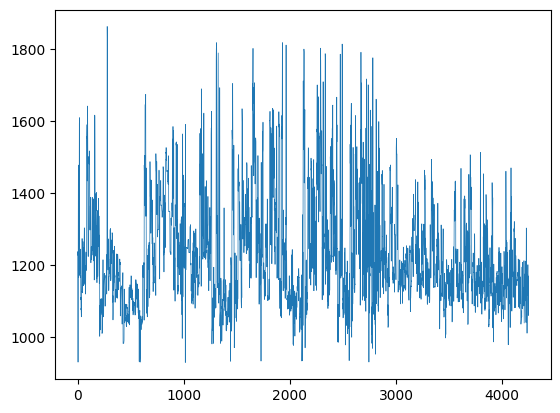

In [73]:
plt.plot(ylag, linewidth =0.5) # --> видим 5 частей

In [74]:
# классифицируем на пять квантилей

ylagq5 = mc.Quantiles(ylag, k=5)
ylagq5

Quantiles                 

     Interval        Count
--------------------------
[ 930.41, 1108.67] |   850
(1108.67, 1164.11] |   849
(1164.11, 1230.27] |   849
(1230.27, 1345.70] |   849
(1345.70, 1862.82] |   850

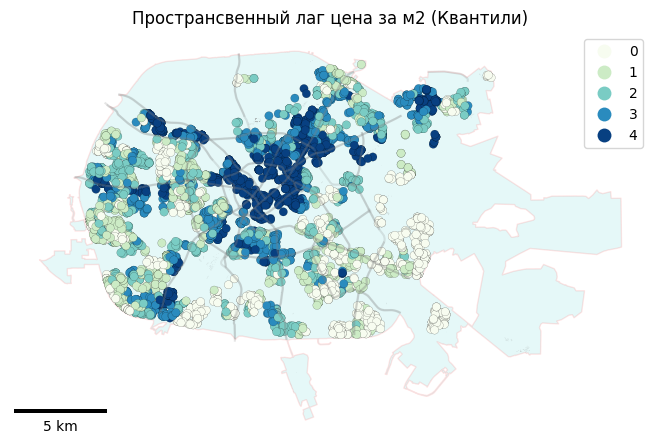

In [75]:
f,ax = plt.subplots (1, figsize = (8.26,5.826)) # 2551x1795 - A5 (dpi-300)

minsk.plot(ax=ax, color = 'c',alpha = .1, edgecolor = 'red')
highways.plot(ax=ax, color = 'grey', alpha = 0.2)
buildings.plot(ax=ax, color='grey', alpha = 0.5)


m17.assign(cl=ylagq5.yb).plot(column='cl', categorical=True,\
                            k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
                            edgecolor= 'k', legend=True)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx = 1,
                       location = 'lower left'
                      ),) # 1 pixel = 1 м
plt.title("Пространсвенный лаг цена за м2 (Квантили)")
plt.show()
#plt.savefig('SpLag.png', dpi=300)

## Пространсвенная автокорреляция - про взаимодействие (отражает общую схожесть)

### H0: пространсвенная случайность - отсутсвие любого паттерна 

### 1) Бинарный случай

In [76]:
# Посмотрели на медиану зависимой переменной
y.median()

1188.0

In [77]:
# Выбрали значения выше медианы
yb = y > y.median()
sum(yb)

2113

In [78]:
labels = ["0 Ниже", "1 Выше"]
yb = [labels[i] for i in 1*yb]

In [79]:
m17['yb'] = yb
m17.head()

,rooms,street_nam,house_numb,building_n,price_m2,area_total,year,house_type,x,y,...,hospitals_dist,schools_dist,transport_dist,highways_dist,industrial_dist,Istoch,foundat,floors,price_m2_log,yb
FID_,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,Героев 120 Дивизии ул.,27.0,0.0,1284.0,49.0,2012.0,1.0,27.723200,53.942500,...,800.867506,23.757774,271.166518,1510.844907,310.476462,Подземн,1.0,9,7.157735,1 Выше
1.0,1.0,Героев 120 Дивизии ул.,29.0,0.0,1327.0,49.0,2012.0,1.0,27.723900,53.942000,...,869.830404,54.368808,204.024323,1562.897062,238.669685,Подземн,1.0,9,7.190676,1 Выше
3.0,1.0,Героев 120 Дивизии ул.,29.0,0.0,1633.0,49.0,2013.0,1.0,27.723900,53.942000,...,869.830404,54.368808,204.024323,1562.897062,238.669685,Подземн,1.0,9,7.398174,1 Выше
4.0,1.0,Героев 120 Дивизии ул.,33.0,0.0,1190.0,47.0,2012.0,1.0,27.724920,53.941501,...,948.045267,62.013553,128.830758,1615.929085,155.229325,Подземн,1.0,9,7.081709,1 Выше
5.0,1.0,Гуртьева ул.,14.0,0.0,854.0,48.0,1970.0,5.0,27.741279,53.958415,...,188.533131,1964.565168,302.368797,1052.783426,190.767202,Подземн,1.0,5,6.749931,0 Ниже


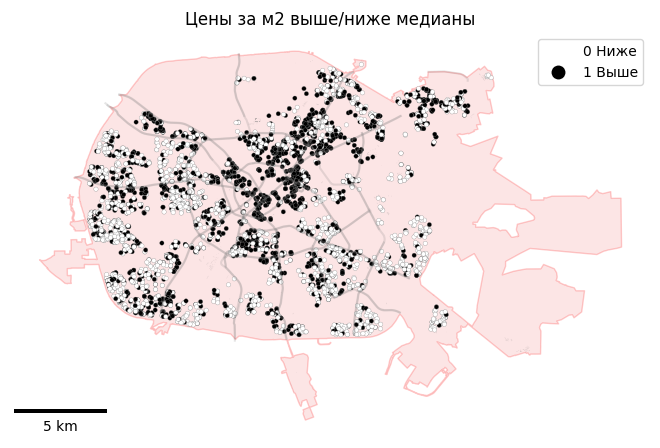

In [80]:
f,ax = plt.subplots (1, figsize = (8.26,5.826))

minsk.plot(ax=ax, color = 'lightcoral',alpha = .2, edgecolor = 'red')
highways.plot(ax=ax, color = 'grey', alpha = 0.2)
buildings.plot(ax=ax, color='grey', alpha = 0.5)

m17.plot(column='yb', cmap='binary',
         ax=ax,
         edgecolor='grey',
         linewidth = 0.2,
         legend=True,
         markersize = 10)

ax.add_artist(ScaleBar(dx = 1,
                       location = 'lower left'
                      ),) # 1 pixel = 1 м
plt.title("Цены за м2 выше/ниже медианы")
ax.set_axis_off()
plt.show()
#plt.savefig('Binary.png', format='png', dpi=300)

### 2) Непрерывный случай

In [81]:
# Moran I Test
import esda # работа с автокорреляцией
import seaborn as sbn

np.random.seed(12345)
mi = esda.moran.Moran(y, kw)
mi.I

0.45545928158423066

In [82]:
mi.EI # ожидаемое значение при допущении нормальности

-0.00023551577955723034

In [83]:
max(mi.sim) # моделируем нулевую гипотезу (случайные пространсвенные перестановки)

0.14458221561293727

/tmp/ipykernel_38262/2099604969.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(mi.sim, #(если n(перестановок)>0) вектор значений I для переставленных выборок


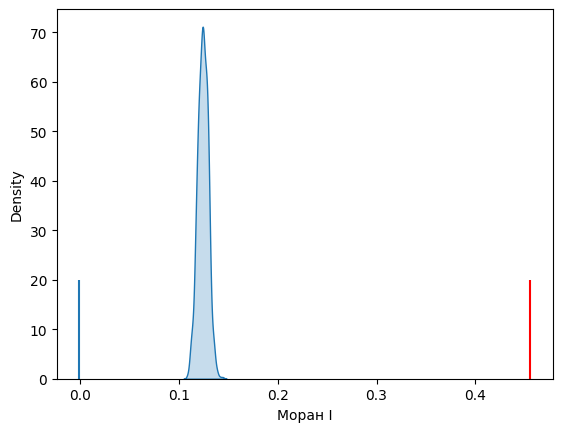

In [84]:
sbn.kdeplot(mi.sim, #(если n(перестановок)>0) вектор значений I для переставленных выборок
            shade=True)
plt.vlines(mi.I, 0, 20, color = 'r')
plt.vlines(mi.EI, 0,20)
plt.xlabel("Моран I")
plt.savefig('moran-p.png', dpi=300)

In [180]:
mi.p_sim # --> отклоняем пространсвенную случайность

# (если перестановки>0)
# p-значение, основанное на перестановках
# H0: альтернатива пространственной случайности
# наблюдаемое I является экстремальным (высоким или низким)
# полученных на основе перестановок.

0.001

### 3) Локальная автокорреляция (ЛИЗА)

<function matplotlib.pyplot.show(close=None, block=None)>

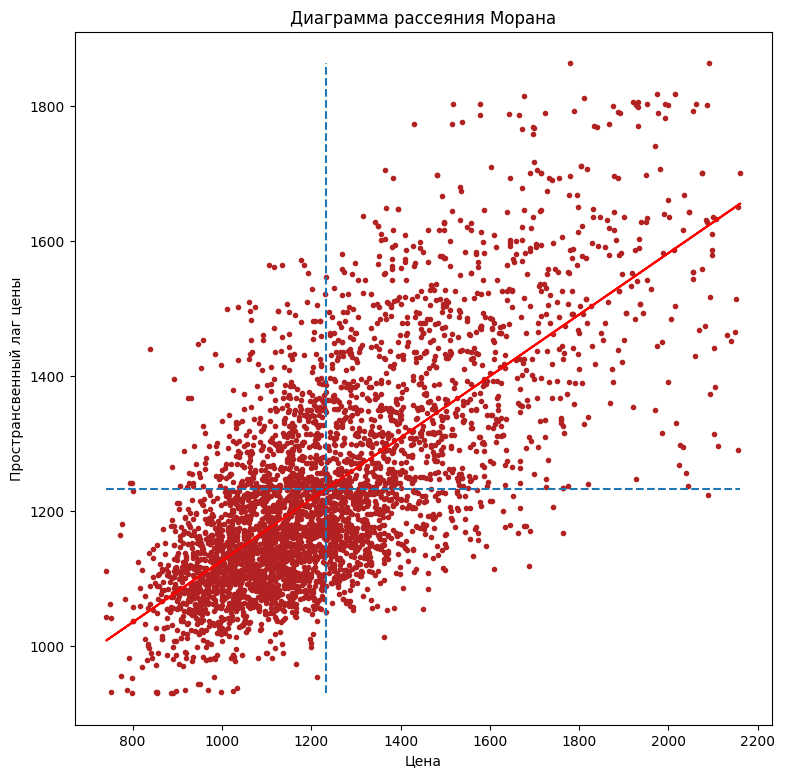

In [86]:
# Отобразим диаграмму рассеяния Морана - отражающую зависимость
# зависимой переменной от ее пространсвенного лага, в нашем случае
# это линейная положительная зависимость, визуализирующая взаимодействие. 

y = m17['price_m2']
b, a = np.polyfit(y, ylag, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(y, ylag, '.', color = 'firebrick')

# dashed vert at mean of the price
plt.vlines(y.mean(), ylag.min(), ylag.max(), linestyle='--')

# dashed horizontal at mean of lagged price

plt.hlines (ylag.mean(), y.min(), y.max(), linestyle = '--')

# red line of best fit using global moran
plt.plot(y, a + b*y, 'r')
plt.title('Диаграмма рассеяния Морана')
plt.ylabel('Пространсвенный лаг цены')
plt.xlabel('Цена')
plt.show
#plt.savefig('moran_scatter.png', dpi=300)

In [87]:
# Расчитываем Локальный Индекс Морана

li = esda.moran.Moran_Local(y, kw)

<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()


In [88]:
li.q # расположение квадрантов 1 НН, 2 LH, 3 LL, 4 HL

array([4, 1, 1, ..., 3, 3, 3])

In [89]:
# обозначаем случаи вне пространсвенной случайности
sig = 1 * (li.p_sim < 0.05)
sig.sum()

1926

In [90]:
# определям квадранты булевым произведением

hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig* li.q==2)
diamond = 4 * (sig * li.q==4)

In [91]:
# складываем все в один массив

spots = hotspot + coldspot + doughnut + diamond
spots

array([0, 0, 0, ..., 3, 3, 3])

In [92]:
# для каждого значения в массиве назначаем квадрант, полученный массив
# визуализируем категориальными значениями

spot_labels = ['0 нз', '1 хотспоты (спутники)', '2 ядра', '3 колдспоты', '4 испытывающие влияние 1 и 2']
labels = [spot_labels[i] for i in spots]
labels

['0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '3 колдспоты',
 '3 колдспоты',
 '0 нз',
 '0 нз',
 '1 хотспоты (спутники)',
 '0 нз',
 '2 ядра',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '1 хотспоты (спутники)',
 '1 хотспоты (спутники)',
 '1 хотспоты (спутники)',
 '1 хотспоты (спутники)',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '4 испытывающие влияние 1 и 2',
 '0 нз',
 '3 колдспоты',
 '3 колдспоты',
 '3 колдспоты',
 '3 колдспоты',
 '4 испытывающие влияние 1 и 2',
 '0 нз',
 '3 колдспоты',
 '3 колдспоты',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '3 колдспоты',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '4 испытывающие влияние 1 и 2',
 '0 нз',
 '0 нз',
 '4 испытывающие влияние 1 и 2',
 '0 нз',
 '4 испытывающие влияние 1 и 2',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '0 нз',
 '4 испытывающие влияние 1 и 2',
 '0 нз',
 '0 нз',
 '4 испытывающие влияние 1 и 2',
 '0 нз'

<function matplotlib.pyplot.show(close=None, block=None)>

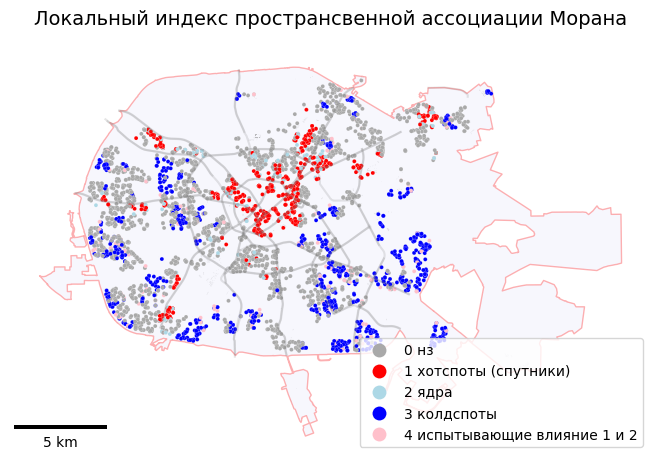

In [93]:
from matplotlib import colors 
hmap = colors.ListedColormap(['darkgrey', 'red', 'lightblue', 'blue','pink'])

f,ax = plt.subplots (1, figsize = (8.26,5.826))

minsk.plot(ax=ax, color = 'lavender',alpha = .3, edgecolor = 'red')
highways.plot(ax=ax, color = 'grey', alpha = 0.2)
buildings.plot(ax=ax, color='grey', alpha = 0.5)

m17.assign(cl=labels).plot(column='cl', categorical=True,
                           k=2, cmap=hmap,
                           markersize=8,
                           linewidth=0.1, ax=ax,
                           edgecolor='white',
                           legend=True
                          )
ax.set_title('Локальный индекс пространсвенной ассоциации Морана',
             fontsize = 14)
#ax.legend(loc='lower left')
# scalebar = AnchoredSizeBar(ax.transData, 1, "1 Meter", 9)
ax.add_artist(ScaleBar(dx = 1,
                       location = 3
                       )) # 1 pixel = 1 м
# m17.legend(frameon=False, loc=0, ncol=2)
ax.set_axis_off()
plt.show
#plt.savefig('LISA.png', format='png', dpi=300)

## GWR

In [71]:
from mgwr.gwr import GWR, MGWR # моделирование ГВР и МГВР
from mgwr.sel_bw import Sel_BW # выбор полосы пропускания
from mgwr.utils import compare_surfaces, truncate_colormap

/home/milvari/EnvProj/myenv/lib/python3.10/site-packages/spreg/user_output.py:12: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix


In [86]:
# подготовка исходных данных
# выбор зависимой переменной, факторов

y = m17['price_m2_log'].values.reshape((-1,1))
x = m17[['rooms', 'area_total', 'year', 'house_type',
         'centre_dist', 'parks_dist','metro_dist', 'hospitals_dist',
         'schools_dist','transport_dist',
         'highways_dist',#'industrial_dist',
         'heavy_dist',
         'floors' #'foundat'
        ]].values

# получение списка координат
u = m17['x']
v = m17['y']
coords = list(zip(u,v))

# нормализация данных
x = (x-x.mean(axis=0))/x.std(axis=0)
y = y.reshape((-1,1))
y = (y-y.mean(axis=0)/y.std(axis=0))

In [87]:
# калибровка ГВР-модели
%time
gwr_selector = Sel_BW(coords, # координаты
                      y,x, # зависимая и независимые переменные
                      kernel = 'bisquare', # тип ядра
                      fixed = False).search(criterion = 'AICc',
                                            verbose = True)

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 8.82 µs
Bandwidth:  1664.0 , score:  -4180.95
Bandwidth:  2651.0 , score:  -3939.82
Bandwidth:  1055.0 , score:  -4341.06
Bandwidth:  678.0 , score:  -4447.60
Bandwidth:  445.0 , score:  -4542.73
Bandwidth:  301.0 , score:  -4605.58
Bandwidth:  212.0 , score:  -4621.61
Bandwidth:  157.0 , score:  -4585.05
Bandwidth:  246.0 , score:  -4621.46
Bandwidth:  191.0 , score:  -4619.49
Bandwidth:  225.0 , score:  -4620.08
Bandwidth:  204.0 , score:  -4620.57
Bandwidth:  217.0 , score:  -4621.38
Bandwidth:  209.0 , score:  -4620.38
Bandwidth:  214.0 , score:  -4620.92
Bandwidth:  211.0 , score:  -4620.78
Bandwidth:  213.0 , score:  -4621.76


In [88]:
print(gwr_selector)

213.0


In [89]:
gwr = GWR(coords,
          y, x,
          gwr_selector,
          kernel ='bisquare',
          fixed = False)
res = gwr.fit()

print('aicc:', res.aicc)
print ('ENP:', res.ENP)
print('sigma2:', res.sigma2)
print('R2:', res.R2)
print('D2', res.R2)
print('Adjucted R2:', res.adj_R2)
print('std_res: ',res.std_res)

In [90]:
res.summary()

Model type                                                         Gaussian
Number of observations:                                                4247
Number of covariates:                                                    14

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            106.960
Log-likelihood:                                                    1791.466
AIC:                                                              -3554.931
AICc:                                                             -3552.818
BIC:                                                             -35255.387
R2:                                                                   0.271
Adj. R2:                                                              0.269

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

/home/milvari/EnvProj/myenv/lib/python3.10/site-packages/spglm/iwls.py:111: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  betas = np.zeros((x.shape[1], 1), np.float)


In [94]:
room1 = m17[m17['rooms'] == 1.0]
room1.to_file('room1.shp')

room2 = m17[m17['rooms'] == 2.0]
room2.to_file('room2.shp')

room3 = m17[m17['rooms'] ==3.0]
room3.to_file('room3.shp')

/tmp/ipykernel_67771/4191031331.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  room1.to_file('room1.shp')
/tmp/ipykernel_67771/4191031331.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  room2.to_file('room2.shp')
/tmp/ipykernel_67771/4191031331.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  room3.to_file('room3.shp')


# GWR для однокомнатных квартир

In [165]:
# подготовка исходных данных
# выбор зависимой переменной, факторов

y = room1['price_m2_log'].values.reshape((-1,1))
x = room1[['area_total'
           ,'year'
           ,'house_type'
           ,'centre_dist'
           ,'parks_dist'
           ,'metro_dist'
           ,'hospitals_dist'
           ,'schools_dist'
           ,'transport_dist'
           ,'highways_dist'
           ,'industrial_dist'
           ,'heavy_dist'
           ,'floors' #'foundat'
        ]].values

# получение списка координат
u = room1['x']
v = room1['y']
coords = list(zip(u,v))

# нормализация данных
x = (x-x.mean(axis=0))/x.std(axis=0)
y = y.reshape((-1,1))
y = (y-y.mean(axis=0)/y.std(axis=0))

In [188]:
# калибровка ГВР-модели
%time
sel = Sel_BW(coords, # координаты
                      y,x, # зависимая и независимые переменные
                      kernel = 'bisquare', # тип ядра
                      fixed = False).search(criterion = 'AICc')

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 5.96 µs


In [167]:
gwr = GWR(coords,
          y, x, 
          gwr_selector,
          kernel ='bisquare',
          fixed = False)
r1 = gwr.fit()

In [168]:
r1.summary();

Model type                                                         Gaussian
Number of observations:                                                1129
Number of covariates:                                                    14

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             18.203
Log-likelihood:                                                     727.984
AIC:                                                              -1427.969
AICc:                                                             -1425.537
BIC:                                                              -7819.229
R2:                                                                   0.216
Adj. R2:                                                              0.207

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

/home/milvari/EnvProj/myenv/lib/python3.10/site-packages/spglm/iwls.py:111: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  betas = np.zeros((x.shape[1], 1), np.float)


In [226]:
#from scipy.spatial import Voronoi,voronoi_plot_2d
#from shapely.geometry import Point, MultiPolygon, Polygon

points_room1 = (list(zip(room1['x'], room1['y'])))
points_room1 = np.array(points_room1)

In [227]:
kw = Kernel(points_room1,
            fixed = False,
            k = 35) # адаптивные - 35 соседей
kw.transform = 'r'

In [228]:
room1['std_res'] = r1.std_res;

/home/milvari/EnvProj/myenv/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [229]:
# Moran I Test
np.random.seed(12345)
mi = esda.moran.Moran(room1['std_res'], kw)
mi.I

0.037108077778500004

In [230]:
mi.EI # ожидаемое значение при допущении нормальности

-0.0008865248226950354

In [231]:
max(mi.sim) # моделируем нулевую гипотезу (случайные пространсвенные перестановки)

0.09872640055908141

/tmp/ipykernel_67771/2099604969.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(mi.sim, #(если n(перестановок)>0) вектор значений I для переставленных выборок


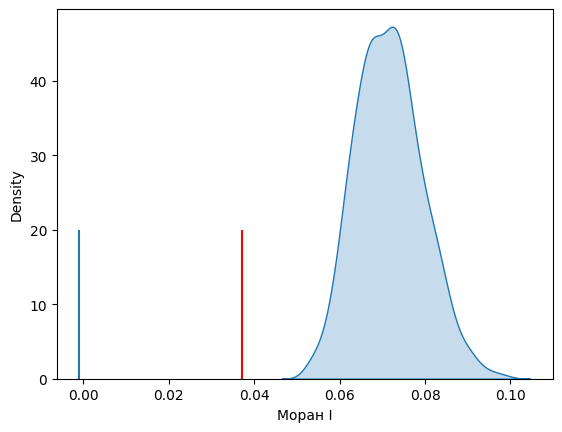

In [232]:
sbn.kdeplot(mi.sim, #(если n(перестановок)>0) вектор значений I для переставленных выборок
            shade=True)
plt.vlines(mi.I, 0, 20, color = 'r')
plt.vlines(mi.EI, 0,20)
plt.xlabel("Моран I")
plt.savefig('moran-p.png', dpi=300)

In [233]:
mi.p_sim # --> отклоняем пространсвенную случайность

# (если перестановки>0)
# p-значение, основанное на перестановках
# H0: альтернатива пространственной случайности
# наблюдаемое I является экстремальным (высоким или низким)
# полученных на основе перестановок.

0.001

# GWR для двухкомнатных квартир

In [235]:
# подготовка исходных данных
# выбор зависимой переменной, факторов

y = room2['price_m2_log'].values.reshape((-1,1))
x = room2[['area_total'
           ,'year'
           ,'house_type'
           ,'centre_dist'
           ,'parks_dist'
           ,'metro_dist'
           ,'hospitals_dist'
           ,'schools_dist'
           ,'transport_dist'
           ,'highways_dist'
           ,'industrial_dist'
           ,'heavy_dist'
           ,'floors' #'foundat'
        ]].values

# получение списка координат
u = room2['x']
v = room2['y']
coords = list(zip(u,v))

# нормализация данных
x = (x-x.mean(axis=0))/x.std(axis=0)
y = y.reshape((-1,1))
y = (y-y.mean(axis=0)/y.std(axis=0))

In [236]:
# калибровка ГВР-модели
%time
sel = Sel_BW(coords, # координаты
                      y,x, # зависимая и независимые переменные
                      kernel = 'bisquare', # тип ядра
                      fixed = False).search(criterion = 'AICc')

CPU times: user 1 µs, sys: 3 µs, total: 4 µs
Wall time: 7.15 µs


In [237]:
gwr = GWR(coords,
          y, x, 
          gwr_selector,
          kernel ='bisquare',
          fixed = False)
r2 = gwr.fit()

In [201]:
r2.summary();

Model type                                                         Gaussian
Number of observations:                                                1480
Number of covariates:                                                    14

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             35.870
Log-likelihood:                                                     652.688
AIC:                                                              -1277.375
AICc:                                                             -1275.048
BIC:                                                             -10665.633
R2:                                                                   0.236
Adj. R2:                                                              0.229

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

/home/milvari/EnvProj/myenv/lib/python3.10/site-packages/spglm/iwls.py:111: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  betas = np.zeros((x.shape[1], 1), np.float)


In [238]:
#from scipy.spatial import Voronoi,voronoi_plot_2d
#from shapely.geometry import Point, MultiPolygon, Polygon

points_room2 = (list(zip(room2['x'], room2['y'])))
points_room2 = np.array(points_room2)

In [239]:
kw = Kernel(points_room2,
            fixed = False,
            k = 38) # адаптивные - 38 соседей

In [240]:
room2['std_res'] = r2.std_res;

/home/milvari/EnvProj/myenv/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [241]:
# Moran I Test
np.random.seed(12345)
mi = esda.moran.Moran(room2['std_res'], kw)
mi.I

0.02519416759642634

In [242]:
mi.EI # ожидаемое значение при допущении нормальности

-0.000676132521974307

In [243]:
max(mi.sim) # моделируем нулевую гипотезу (случайные пространсвенные перестановки)

0.09188847900941297

/tmp/ipykernel_67771/2099604969.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(mi.sim, #(если n(перестановок)>0) вектор значений I для переставленных выборок


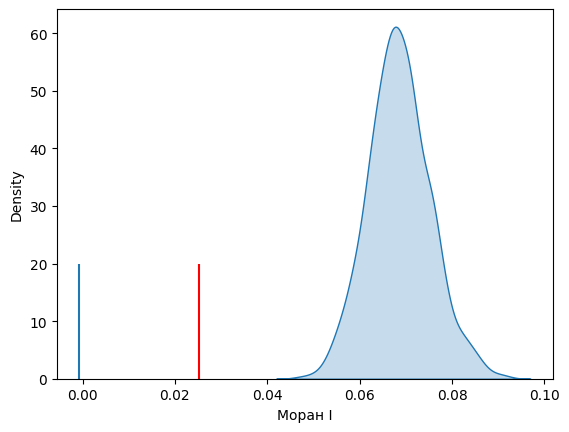

In [244]:
sbn.kdeplot(mi.sim, #(если n(перестановок)>0) вектор значений I для переставленных выборок
            shade=True)
plt.vlines(mi.I, 0, 20, color = 'r')
plt.vlines(mi.EI, 0,20)
plt.xlabel("Моран I")
plt.savefig('moran-p.png', dpi=300)

In [245]:
mi.p_sim # --> отклоняем пространсвенную случайность

# (если перестановки>0)
# p-значение, основанное на перестановках
# H0: альтернатива пространственной случайности
# наблюдаемое I является экстремальным (высоким или низким)
# полученных на основе перестановок.

0.001

# GWR для трехкомнатных квартир

In [246]:
# подготовка исходных данных
# выбор зависимой переменной, факторов

y = room3['price_m2_log'].values.reshape((-1,1))
x = room3[['area_total'
           ,'year'
           ,'house_type'
           ,'centre_dist'
           ,'parks_dist'
           ,'metro_dist'
           ,'hospitals_dist'
           ,'schools_dist'
           ,'transport_dist'
           ,'highways_dist'
           ,'industrial_dist'
           ,'heavy_dist'
           ,'floors' #'foundat'
        ]].values

# получение списка координат
u = room3['x']
v = room3['y']
coords = list(zip(u,v))

# нормализация данных
x = (x-x.mean(axis=0))/x.std(axis=0)
y = y.reshape((-1,1))
y = (y-y.mean(axis=0)/y.std(axis=0))

In [247]:
# калибровка ГВР-модели
%time
sel = Sel_BW(coords, # координаты
                      y,x, # зависимая и независимые переменные
                      kernel = 'bisquare', # тип ядра
                      fixed = False).search(criterion = 'AICc')

CPU times: user 1e+03 ns, sys: 3 µs, total: 4 µs
Wall time: 9.06 µs
Bandwidth:  505.0 , score:  -1024.71
Bandwidth:  775.0 , score:  -962.32
Bandwidth:  338.0 , score:  -1058.31
Bandwidth:  235.0 , score:  -1066.20
Bandwidth:  171.0 , score:  -1050.72
Bandwidth:  274.0 , score:  -1065.72
Bandwidth:  210.0 , score:  -1063.56
Bandwidth:  250.0 , score:  -1066.45
Bandwidth:  259.0 , score:  -1066.46
Bandwidth:  265.0 , score:  -1066.14
Bandwidth:  256.0 , score:  -1066.40
Bandwidth:  262.0 , score:  -1066.53
Bandwidth:  263.0 , score:  -1066.59
Bandwidth:  264.0 , score:  -1066.20


In [248]:
gwr = GWR(coords,
          y, x, 
          gwr_selector,
          kernel ='bisquare',
          fixed = False)
r3 = gwr.fit()

In [249]:
r3.summary();

Model type                                                         Gaussian
Number of observations:                                                1212
Number of covariates:                                                    14

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             33.601
Log-likelihood:                                                     453.050
AIC:                                                               -878.100
AICc:                                                              -875.699
BIC:                                                              -8472.232
R2:                                                                   0.287
Adj. R2:                                                              0.280

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

/home/milvari/EnvProj/myenv/lib/python3.10/site-packages/spglm/iwls.py:111: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  betas = np.zeros((x.shape[1], 1), np.float)


In [250]:
#from scipy.spatial import Voronoi,voronoi_plot_2d
#from shapely.geometry import Point, MultiPolygon, Polygon

points_room3 = (list(zip(room3['x'], room3['y'])))
points_room3 = np.array(points_room3)

In [251]:
kw = Kernel(points_room1,
            fixed = False,
            k = 18) # адаптивные - 35 соседей
kw.transform = 'r'

/home/milvari/EnvProj/myenv/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [252]:
room1['std_res'] = r1.std_res;

/home/milvari/EnvProj/myenv/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [253]:
# Moran I Test
np.random.seed(12345)
mi = esda.moran.Moran(room1['std_res'], kw)
mi.I

0.09891592346442284

In [254]:
mi.EI # ожидаемое значение при допущении нормальности

-0.0008865248226950354

In [255]:
max(mi.sim) # моделируем нулевую гипотезу (случайные пространсвенные перестановки)

0.17257250609564706

/tmp/ipykernel_67771/2099604969.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(mi.sim, #(если n(перестановок)>0) вектор значений I для переставленных выборок


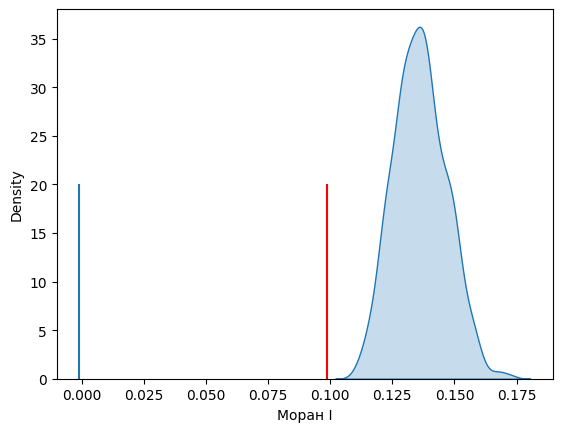

In [256]:
sbn.kdeplot(mi.sim, #(если n(перестановок)>0) вектор значений I для переставленных выборок
            shade=True)
plt.vlines(mi.I, 0, 20, color = 'r')
plt.vlines(mi.EI, 0,20)
plt.xlabel("Моран I")
plt.savefig('moran-p.png', dpi=300)

In [257]:
mi.p_sim # --> отклоняем пространсвенную случайность

# (если перестановки>0)
# p-значение, основанное на перестановках
# H0: альтернатива пространственной случайности
# наблюдаемое I является экстремальным (высоким или низким)
# полученных на основе перестановок.

0.001

<AxesSubplot: >

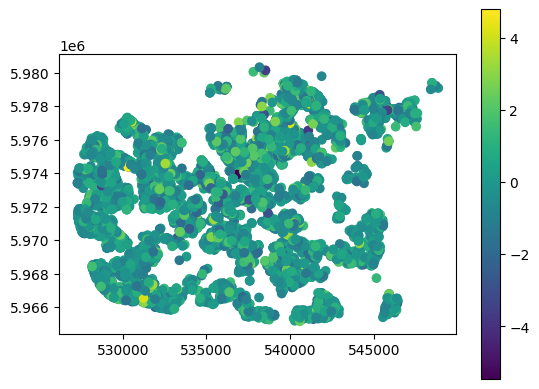

In [141]:
m17['std_res'] = res.std_res
m17.plot('std_res', legend=True)

(array([  1.,   0.,   0.,   0.,   1.,   1.,   3.,   5.,   7.,   4.,  10.,
         15.,  23.,  52.,  97., 167., 247., 418., 511., 660., 649., 642.,
        584., 434., 371., 220., 209., 140.,  95.,  80.,  58.,  28.,  18.,
         13.,  12.,   3.,   4.,   4.,   0.,   2.]),
 array([-5.45507391, -5.19904973, -4.94302555, -4.68700137, -4.43097719,
        -4.17495301, -3.91892883, -3.66290465, -3.40688047, -3.15085628,
        -2.8948321 , -2.63880792, -2.38278374, -2.12675956, -1.87073538,
        -1.6147112 , -1.35868702, -1.10266284, -0.84663866, -0.59061448,
        -0.33459029, -0.07856611,  0.17745807,  0.43348225,  0.68950643,
         0.94553061,  1.20155479,  1.45757897,  1.71360315,  1.96962733,
         2.22565151,  2.48167569,  2.73769988,  2.99372406,  3.24974824,
         3.50577242,  3.7617966 ,  4.01782078,  4.27384496,  4.52986914,
         4.78589332]),
 <BarContainer object of 40 artists>)

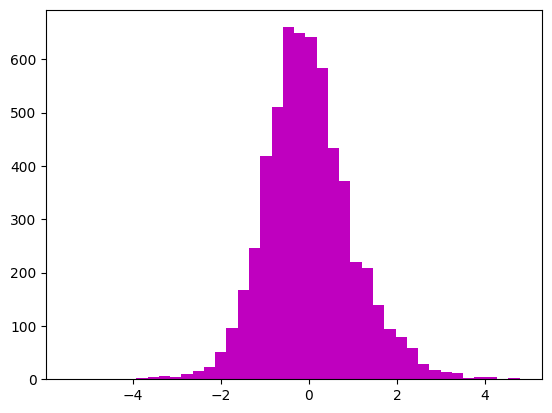

In [144]:
res = m17['std_res'].values
plt.hist(res, bins=40, color='m')

In [147]:
stat,p = scipy.stats.normaltest(m17['std_res'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=245.667, p-value=0.000
Отклонить гипотезу о нормальности


## DBSCAN

In [47]:
import contextily as cx
from libpysal.cg.alpha_shapes import alpha_shape_auto

import sys
sys.path.append('../')
try:
    from esda.adbscan import ADBSCAN, get_cluster_boundary, remap_lbls
except:
    print("Import from local folder...")
    import sys
    sys.path.append("../esda")
    from adbscan import ADBSCAN, get_cluster_boundary, remap_lbls

In [9]:
m17.shape[0] * 0.01 #1% of the overall sample size 
                    # for the min_samples parameter

59.06

In [44]:
# pull out the projected coords into separate colunms
m17['X']=m17.geometry.x
m17['Y']=m17.geometry.y

m17.head()

,rooms,street_nam,house_numb,building_n,price_m2,area_total,year,house_type,x,y,geometry,b,k,kb,m,p,sb,X,Y
FID_,,,,,,,,,,,,,,,,,,,
5399.0,2.0,Тикоцкого ул.,4.0,0.0,741.0,49.9,1978.0,п,27.626329,53.957141,POINT (541097.489 5978934.799),0,0,0,0,1,0,541097.488898,5.978935e+06
11230.0,4.0,Мавра ул.,25.0,0.0,741.0,103.9,2014.0,п,27.490928,53.897980,POINT (532258.617 5972282.628),0,0,0,0,1,0,532258.617002,5.972283e+06
9305.0,2.0,Шпилевского ул.,52.0,0.0,743.0,74.0,2014.0,п,27.565100,53.846600,POINT (537177.914 5966602.562),0,0,0,0,1,0,537177.914096,5.966603e+06
4084.0,2.0,Васнецова ул.,9.0,0.0,750.0,44.0,1962.0,п,27.617769,53.873171,POINT (540617.226 5969587.624),0,0,0,0,1,0,540617.225659,5.969588e+06
8637.0,3.0,Радиаторный 2-й пер.,20.0,0.0,752.0,166.2,2010.0,сб,27.482465,53.925386,POINT (531681.773 5975327.938),0,0,0,0,0,1,531681.772721,5.975328e+06


In [53]:
# we will use 500 m radious - eps (at least about 25 properties per sq)

# run ahead
%time
adbs = ADBSCAN(600, 60, pct_exact=0.5, reps=10, keep_solus=True)
np.random.seed(1234)
adbs.fit(m17)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


ADBSCAN(eps=600, keep_solus=True, min_samples=60, pct_exact=0.5, reps=10)

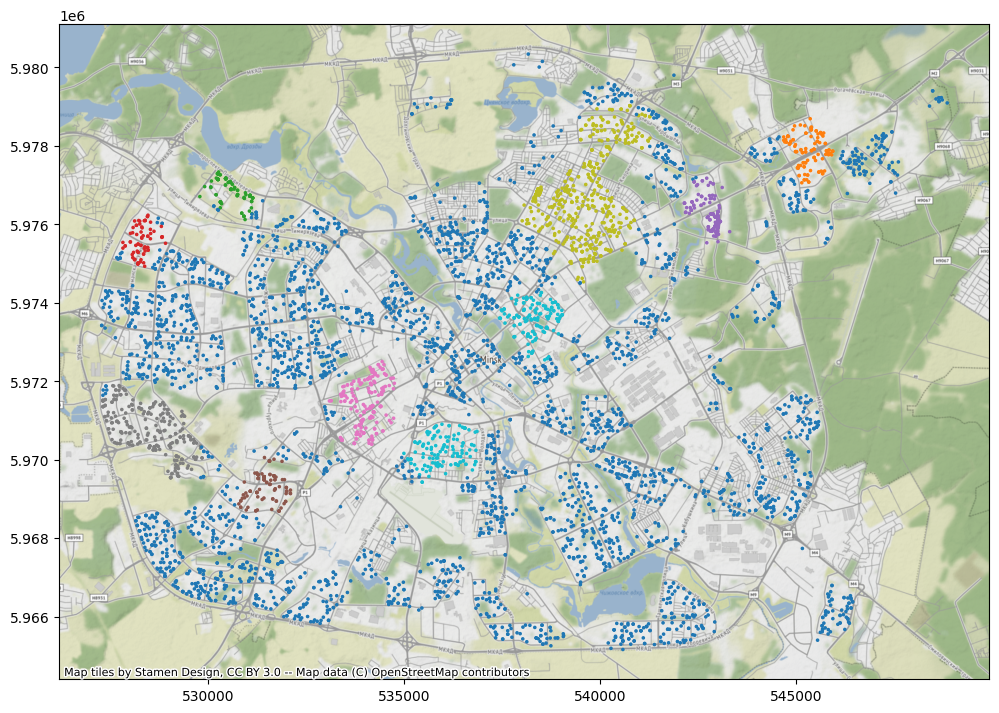

In [54]:
ax = m17.assign(lbls=adbs.votes['lbls']).plot(column='lbls',
                                            categorical=True,
                                            markersize=2.5,
                                            figsize=(12,12)
                                            )
cx.add_basemap(ax, crs=m17.crs.to_string())

In [55]:
polys = get_cluster_boundary(adbs.votes['lbls'],
                             m17
                             ,crs=m17.crs)

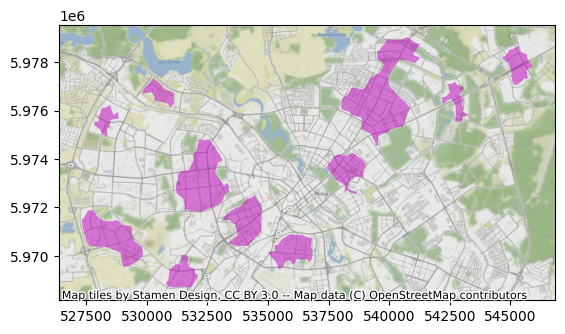

In [56]:
# plot those
ax = polys.plot(alpha=.5, color='m')
cx.add_basemap(ax, crs=polys.crs.to_string())